### Predicting Future Stock  Market Prices with Additive Regression in python

By Andi Haikal

## Purpose
1. To create and show a quick way to predict time series based data using GAM( General Addidtive model ) from the Facebook Prophet derived algorithm which is basicaly additive regression .
2. To show how much data gives the best fit and the most accurate results.

## Example
* AIRBNB (ABNB)


Folowing the data was provide on this link https://finance.yahoo.com/quote/ABNB/history?period1=1638144000&period2=1701216000&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=true


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot

import datetime as dt
from datetime import date
from datetime import timedelta
from prophet import Prophet

%matplotlib inline
import os
import io

import warnings
warnings.filterwarnings("ignore")


Importing plotly failed. Interactive plots will not work.


In [2]:
stock = pd.read_csv('ABNB1.csv') # 4 years data from 2020 to 2023
print("Number of observation in Airbnb price dataset:", stock.shape)

stock.head()

Number of observation in Airbnb price dataset: (746, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-10,146.000000,165.000000,141.250000,144.710007,144.710007,70447500
1,2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
2,2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
3,2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
4,2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600


In [3]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       746 non-null    object 
 1   Open       746 non-null    float64
 2   High       746 non-null    float64
 3   Low        746 non-null    float64
 4   Close      746 non-null    float64
 5   Adj Close  746 non-null    float64
 6   Volume     746 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 40.9+ KB


In [4]:
len(stock)

746

In [5]:
# Separate categorical and numerical columns
categorical_cols = stock.select_dtypes(include=['object']).columns.tolist()
numerical_cols = stock.select_dtypes(exclude=['object']).columns.tolist()

# Print the separated columns
print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['Date']
Numerical Columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [6]:
for col in categorical_cols:
    print(f"--------------{col.title()}---------------")
    total = stock[col].value_counts() / stock.shape[0]
    percent = stock[col].value_counts(normalize=True) * 100
    stock_cat = pd.concat([total, percent], keys=['total', 'percent'], axis=1)
    print(stock_cat)
    print('\n')

--------------Date---------------
              total   percent
Date                         
2023-11-28  0.00134  0.134048
2020-12-10  0.00134  0.134048
2020-12-11  0.00134  0.134048
2020-12-14  0.00134  0.134048
2020-12-15  0.00134  0.134048
...             ...       ...
2020-12-30  0.00134  0.134048
2020-12-31  0.00134  0.134048
2021-01-04  0.00134  0.134048
2021-01-05  0.00134  0.134048
2021-01-06  0.00134  0.134048

[746 rows x 2 columns]




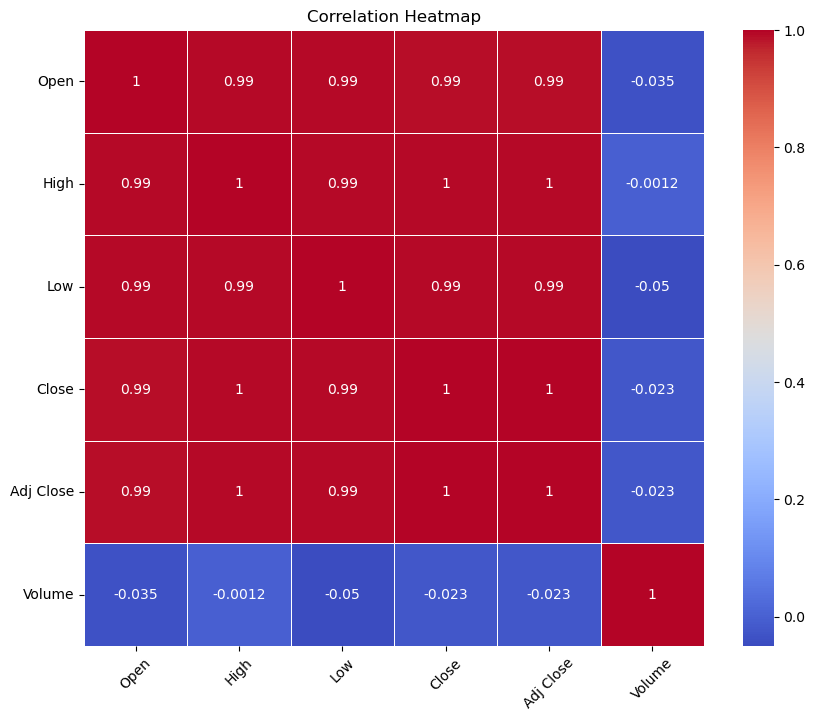

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for the heatmap
df_heatmap = stock[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Calculate the correlation matrix
corr_matrix = df_heatmap.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Customize the plot
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

so here there is strong correlation between high pricese and close price, high prices with adj close

In [8]:
stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-10,146.000000,165.000000,141.250000,144.710007,144.710007,70447500
1,2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
2,2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
3,2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
4,2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600
...,...,...,...,...,...,...,...
741,2023-11-21,128.000000,128.050003,124.930000,126.820000,126.820000,4587100
742,2023-11-22,127.750000,130.580002,127.709999,129.039993,129.039993,3973900
743,2023-11-24,129.050003,129.589996,127.779999,128.369995,128.369995,2058900
744,2023-11-27,127.500000,129.559998,125.849998,129.000000,129.000000,4408400


In [10]:

stock['Date'] = pd.to_datetime(stock['Date']).dt.strftime('%m/%d/%y')
stock['Date_ts'] = pd.to_datetime(stock['Date_ts']).dt.strftime('%m-%d-%y')

stock

,Date,Open,High,Low,Close,Adj Close,Volume,Date_ts
0,12/10/20,146.000000,165.000000,141.250000,144.710007,144.710007,70447500,12-10-20
1,12/11/20,146.550003,151.500000,135.100006,139.250000,139.250000,26980800,12-11-20
2,12/14/20,135.000000,135.300003,125.160004,130.000000,130.000000,16966100,12-14-20
3,12/15/20,126.690002,127.599998,121.500000,124.800003,124.800003,10914400,12-15-20
4,12/16/20,125.830002,142.000000,124.910004,137.990005,137.990005,20409600,12-16-20
...,...,...,...,...,...,...,...,...
741,11/21/23,128.000000,128.050003,124.930000,126.820000,126.820000,4587100,11-21-23
742,11/22/23,127.750000,130.580002,127.709999,129.039993,129.039993,3973900,11-22-23
743,11/24/23,129.050003,129.589996,127.779999,128.369995,128.369995,2058900,11-24-23
744,11/27/23,127.500000,129.559998,125.849998,129.000000,129.000000,4408400,11-27-23


In [11]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       746 non-null    object 
 1   Open       746 non-null    float64
 2   High       746 non-null    float64
 3   Low        746 non-null    float64
 4   Close      746 non-null    float64
 5   Adj Close  746 non-null    float64
 6   Volume     746 non-null    int64  
 7   Date_ts    746 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 46.8+ KB


In [12]:
# 3) Create shortened new data frame stock_df2 Only need 2 columns Date? ts and Close and Closing Price
stock2=stock[['Date_ts','Close']]

In [ ]:
#4 Visualize the data. Columns need to be renamed ds and y as that is what Prophet uses.redefine their types,set the parameters for the visualization and then use plt.plot()from matplotlib to create an initial graph of the data 

            ds           y
0   2020-12-10  144.710007
1   2020-12-11  139.250000
2   2020-12-14  130.000000
3   2020-12-15  124.800003
4   2020-12-16  137.990005
..         ...         ...
741 2023-11-21  126.820000
742 2023-11-22  129.039993
743 2023-11-24  128.369995
744 2023-11-27  129.000000
745 2023-11-28  127.559998

[746 rows x 2 columns]


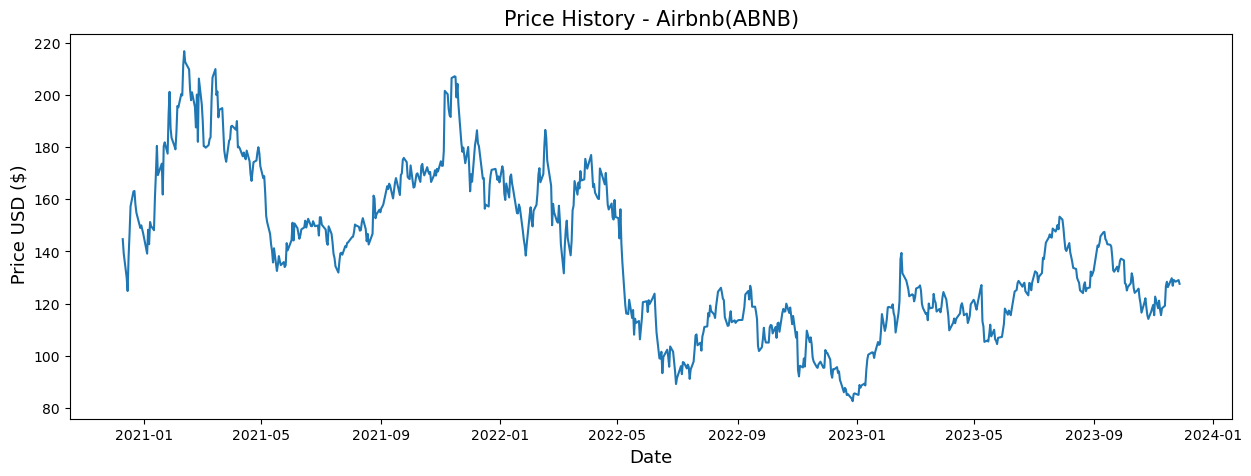

In [13]:
graph_data=stock2

graph_data.columns = ['ds', 'y']
graph_data.y = graph_data.y.astype('float')
graph_data.ds = graph_data.ds.astype('datetime64[ns]')
print(graph_data)
rcParams['figure.figsize'] = 15,5
plt.plot(graph_data.ds, graph_data.y)
plt.title('Price History - Airbnb(ABNB)', fontsize=15)
plt.xlabel('Date',fontsize=13)
plt.xlabel('Date', fontsize=13)
plt.ylabel(' Price USD ($)', fontsize=13);

In [14]:
# 5) Load Prophet, fit and then forecast the data, then plot the forecast data.

pr = Prophet()
pr.fit(graph_data);

21:59:03 - cmdstanpy - INFO - Chain [1] start processing
21:59:03 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future=pr.make_future_dataframe(periods=2,freq='min')
future

,ds
0,2020-12-10 00:00:00
1,2020-12-11 00:00:00
2,2020-12-14 00:00:00
3,2020-12-15 00:00:00
4,2020-12-16 00:00:00
...,...
743,2023-11-24 00:00:00
744,2023-11-27 00:00:00
745,2023-11-28 00:00:00
746,2023-11-28 00:01:00


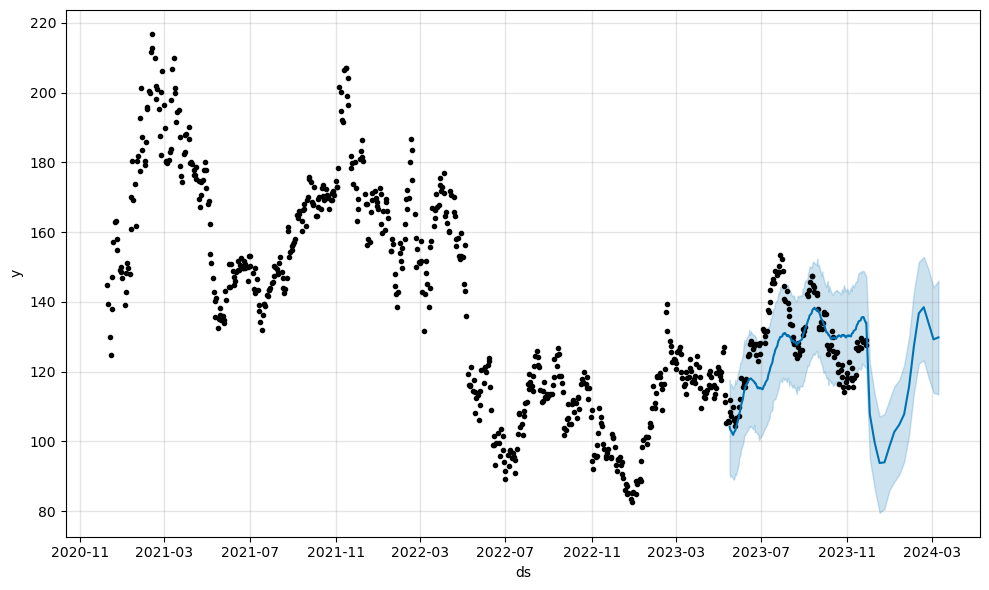

In [16]:
future=pr.make_future_dataframe(periods = 15, freq='w')
forecast_close_prices=pr.predict(future)

figure = pr.plot(forecast_close_prices[-150:])
figure.show()

In [17]:
# 6) Get forecasted values this yields the date, trend , upper and lower bounds, yhat ( forecasted value displayed in the above graph ) , etc
forecast_close_prices[-365:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
396,2022-07-11,106.443290,95.191156,121.008829,106.443290,106.443290,1.306057,1.306057,1.306057,5.876962,5.876962,5.876962,-4.570906,-4.570906,-4.570906,0.0,0.0,0.0,107.749347
397,2022-07-12,106.194634,95.386429,122.570455,106.194634,106.194634,2.337988,2.337988,2.337988,6.322823,6.322823,6.322823,-3.984835,-3.984835,-3.984835,0.0,0.0,0.0,108.532623
398,2022-07-13,105.945979,95.879780,122.948510,105.945979,105.945979,3.094336,3.094336,3.094336,6.463928,6.463928,6.463928,-3.369592,-3.369592,-3.369592,0.0,0.0,0.0,109.040315
399,2022-07-14,105.697323,95.977146,121.994682,105.697323,105.697323,3.533011,3.533011,3.533011,6.265362,6.265362,6.265362,-2.732351,-2.732351,-2.732351,0.0,0.0,0.0,109.230334
400,2022-07-15,105.448668,95.617707,123.047471,105.448668,105.448668,4.451463,4.451463,4.451463,6.531847,6.531847,6.531847,-2.080383,-2.080383,-2.080383,0.0,0.0,0.0,109.900131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,2024-02-11,135.266430,122.332627,151.458564,130.648355,140.424175,1.461192,1.461192,1.461192,-15.730457,-15.730457,-15.730457,17.191649,17.191649,17.191649,0.0,0.0,0.0,136.727621
757,2024-02-18,135.854392,123.215218,152.913089,130.465121,141.745571,2.616645,2.616645,2.616645,-15.730457,-15.730457,-15.730457,18.347102,18.347102,18.347102,0.0,0.0,0.0,138.471037
758,2024-02-25,136.442355,118.151964,149.224027,130.371106,143.119714,-2.634897,-2.634897,-2.634897,-15.730457,-15.730457,-15.730457,13.095561,13.095561,13.095561,0.0,0.0,0.0,133.807458
759,2024-03-03,137.030318,113.898131,144.137375,130.125154,144.738009,-7.803543,-7.803543,-7.803543,-15.730457,-15.730457,-15.730457,7.926914,7.926914,7.926914,0.0,0.0,0.0,129.226774


Part 2 -Filter the dataset to YTD only 

In [19]:
filtered_graph_data = graph_data[graph_data['ds']>= '2023-04-01']
filtered_graph_data

,ds,y
580,2023-04-03,121.459999
581,2023-04-04,118.459999
582,2023-04-05,115.339996
583,2023-04-06,109.690002
584,2023-04-10,112.599998
...,...,...
741,2023-11-21,126.820000
742,2023-11-22,129.039993
743,2023-11-24,128.369995
744,2023-11-27,129.000000


In [20]:
#8 Load Prophet , fit and then forecast the data, then plot the forecasted data
pr2 = Prophet()
pr2.fit(filtered_graph_data);

21:59:43 - cmdstanpy - INFO - Chain [1] start processing
21:59:43 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
future=pr2.make_future_dataframe(periods=2,freq='min')
future

,ds
0,2023-04-03 00:00:00
1,2023-04-04 00:00:00
2,2023-04-05 00:00:00
3,2023-04-06 00:00:00
4,2023-04-10 00:00:00
...,...
163,2023-11-24 00:00:00
164,2023-11-27 00:00:00
165,2023-11-28 00:00:00
166,2023-11-28 00:01:00


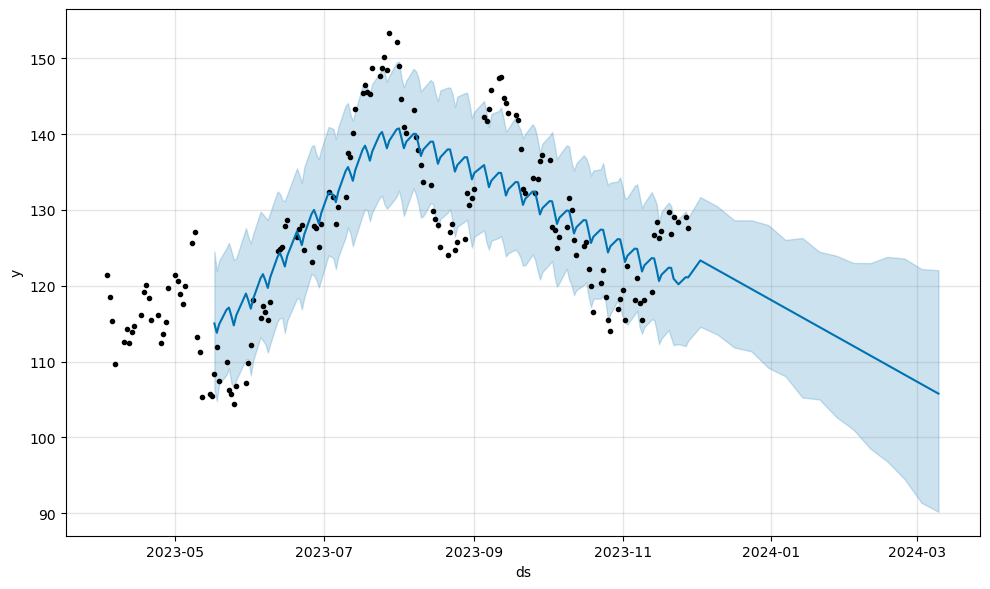

In [22]:
future=pr2.make_future_dataframe(periods=15, freq='w')
forecast_close_prices_2=pr2.predict(future)
figure = pr2.plot(forecast_close_prices_2[-150:])
figure.show()

In [23]:
# 9) Get forecasted values 
forecast_close_prices_2[-50:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
131,2023-10-10,129.966234,120.799777,138.353913,129.966234,129.966234,-0.094951,-0.094951,-0.094951,-0.094951,-0.094951,-0.094951,0.0,0.0,0.0,129.871283
132,2023-10-11,129.786993,120.119400,136.256564,129.786993,129.786993,-1.337796,-1.337796,-1.337796,-1.337796,-1.337796,-1.337796,0.0,0.0,0.0,128.449197
133,2023-10-12,129.607753,118.753130,135.157898,129.607753,129.607753,-2.717604,-2.717604,-2.717604,-2.717604,-2.717604,-2.717604,0.0,0.0,0.0,126.890148
134,2023-10-13,129.428512,119.412364,136.148359,129.428512,129.428512,-1.712590,-1.712590,-1.712590,-1.712590,-1.712590,-1.712590,0.0,0.0,0.0,127.715922
135,2023-10-16,128.890789,120.075041,137.185935,128.890789,128.890789,-0.231935,-0.231935,-0.231935,-0.231935,-0.231935,-0.231935,0.0,0.0,0.0,128.658854
136,2023-10-17,128.711548,120.463956,136.808253,128.711548,128.711548,-0.094951,-0.094951,-0.094951,-0.094951,-0.094951,-0.094951,0.0,0.0,0.0,128.616597
137,2023-10-18,128.532307,118.565098,135.949349,128.532307,128.532307,-1.337796,-1.337796,-1.337796,-1.337796,-1.337796,-1.337796,0.0,0.0,0.0,127.194511
138,2023-10-19,128.353066,117.144301,134.534670,128.353066,128.353066,-2.717604,-2.717604,-2.717604,-2.717604,-2.717604,-2.717604,0.0,0.0,0.0,125.635462
139,2023-10-20,128.173825,118.288892,135.196290,128.173825,128.173825,-1.712590,-1.712590,-1.712590,-1.712590,-1.712590,-1.712590,0.0,0.0,0.0,126.461236
140,2023-10-23,127.636103,118.298248,135.342350,127.636103,127.636103,-0.231935,-0.231935,-0.231935,-0.231935,-0.231935,-0.231935,0.0,0.0,0.0,127.404167


Here we may found that the trend of forecasting data in future might be go down by approximatley  